# Towards a Unified Theory of Bootsy Collins

In another life, I made rap beats, and because it was another life, this involved finding records to sample, and because making rap beats did not make me a lot of money, this involved finding cheap records.

Rather than tracking down exactly what I wanted and paying market rate for it, I would scour thrift stores, garage sales, and record stores that didn't really know how to price their vinyl. A lot of the time I didn't have the luxury of listening before I copped, so I had to judge using whatever information I had. And so, like so many other broke record junkies, I developed a working knowledge of random musicians, producers, engineers and other music industry personnel whose involvement with a project would push me one way or the other.

For my capstone, I adapted this process of triangulating value from the names on the back of funk records from 1978 into an exercise in data science. But instead of deciding whether or not an album is worth three dollars or whatever, I opted for a more standardized metric: Billboard chart position.

I originally planned to something like NLP, using a massive, sparse matrix with a row for each album and a feature for every combination of personnel and role, to predict an album's peak chart position. But after that failed entirely, I changed my strategy.

The final model combines an album's chart trajectory with data on the chart performance of albums with which it shares musicians to predict whether it will move up, down or stay put on the next chart. The data I chose was the Billboard R&B charts between 1975 and 1985.

# Credit Scraping

Getting the chart data was easy: Billboard has a great API with a straightforward python wrapper. However, the album credits proved more elusive.

Originally, I planned to get all the personnel data from Wikipedia. But while it had the bulk of the credits I needed and a bunch of API wrappers to choose from, the lack of of a standard format made it a nightmare to scrape.

Fortunately, it turned out that Allmusic.com, a website I hadn't thought about in some 15 years, had much of the same data nicely formatted. And while its API seemed to be inoperable, it was easy enough to grab the data I needed directly.

I ended up writing a suite of functions that find the credits around 80% of the time.

### 'charto' and 'date_o'
'charto' takes the name and date of a Billboard chart and, using the Billboard API, returns a chart object. The chart can be printed in full, but also indexed numerically into individual chart entries which, in turn, know their name, album title and chart position.

As a bonus, since charts are weekly, 'charto' automatically converts any date into the closest date with a chart associated with it. This was useful but also slow, so after I had pulled enough data, I automated the date adjustment with a big list of chart dates ('all_dates') and the 'date_o' function.

(For the record, Billboard chart dates are 'YYYY-MM-DD' strings.)

In [130]:
import billboard
import pandas as pd
import numpy as np

def charto(chart='r-b-hip-hop-albums', date='1984-01-22'):
    return billboard.ChartData(chart, date)

# pull 'all_dates' for 'date_o'
mt_73_90 = pd.read_csv('mega_track_73_90.csv')
all_dates = mt_73_90['chart_date'].sort_values().drop_duplicates().values

def date_o(d, dates):
    for n in dates:
        if n >= d:
            return n

### 'allmusic_credits'
Given the url for the credits page of an album, this function returns a dictionary with artist names and credit roles. It's the most straightforward of the scraping functions.

In [5]:
from bs4 import BeautifulSoup
import requests
import urllib3
import certifi

# prep 'http'
http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())

# takes a 'url'
# returns scraped 'credits'
def allmusic_credits(url):

    # define 'r' as http request
    r = http.request('GET', url)

    # if status is 200...
    if r.status == 200:

        # pull site into 'soup'
        soup = BeautifulSoup(r.data, 'lxml')

        # initiate 'credits'
        credits = {'artist':[], 'credit':[]}

        # iterate thru artist 'td', strip whitespace and append
        for t in soup.find_all('td', {'class':'artist'}): 
            credits['artist'].append(t.text.strip())
        
        # iterate thru class 'td', strip whitespace and append
        for t in soup.find_all('td', {'class':'credit'}):
            credits['credit'].append(t.text)

        return credits
    else:
        # print error status
        print(r.status)

### 'texty', 'searchy' and 'find_link'

Even though Allmusic has nicer formatting that Wikipedia, automatically turning a title and artist from a Billboard chart into the url for that album's Allmusic page was still a challenge.

Collaborative albums could fall under either artist (or both). Roman numerals and ampersands became numbers and words respectively, but inconsistantly. Artists reused versions of their name for multiple albums. (Dionne Warkwick has two self-titled albums, in addition to one just called "Dionne" and another called "Dionne!")

'texty' standardizes all text inputs by removing punctuation and capitalization, as well as any words specified in the 'skip' input of the function.

In [6]:
import string

def texty(input, skip=['and','the', 'featuring']):

    # prep for punctuation removal
    exclude = set(string.punctuation)

    # remove punctuation and capitalization
    output = (''.join(ch for ch in input if ch not in exclude)).lower().split()
    
    # remove 'skip' words
    output = [w for w in output if w not in skip]

    return output

'searchy' takes in the artist, title and year of an album and returns the results of an Allmusic search for those inputs (cleaned with 'texty') as a list of dictionaries.

In [7]:
def searchy(artist, title, year):
    
    # process artist and title
    a = texty(artist)
    t = texty(title)

    # execute search
    search = f'{a} {t}'.replace(' ', '+')
    url = f'https://www.allmusic.com/search/albums/{search}'

    # make request
    r = http.request('GET', url)

    # if response is good, scrape search results
    if r.status == 200:
        soup = BeautifulSoup(r.data, 'lxml')
        zults = []
        for d in soup.find_all('div', {'class':'info'}):
            entry = {}
            for tag in ['title','artist','year']:
                try:
                    entry[tag] = d.find('div', {'class':tag}).text.strip()
                except AttributeError:
                    entry[tag] = d.find('div', {'class':tag})
                if tag == 'title':
                    entry['album_link'] = d.find('div', {'class':tag}).find('a')['href']
            zults.append(entry)
        return zults

Finally, 'find_link' inspects the search results from 'searchy'. If the 'texty'-cleaned album titles match, it makes sure all the words in the artist name are in the search artist name. If they are, it returns the url from the search result.

This method is imperfect, but it worked well enough to move forward.

In [8]:
def find_link(zults, artist, title, track=True):
    
    # iterate through search results from 'searchy'
    for l in zults:
        if track:
            print(l['artist'], l['title'])

        # skip any results with missing artist or title
        if (l['artist'] == None) or (l['title'] == None):
            continue
            
        # create 'texty'-cleaned list of 'artist','title', and same from search result
        data = []
        for d in [artist, title, l['artist'], l['title']]:
            data.append(set(texty(d)))

        if track:
            print(data)

        # if cleaned titles match ...
        if data[1] == data[3]:
            
            # ... put both artist names in a list and sort
            names = [data[0], data[2]]
            names.sort()

            # if all words in artist name are in result name, return url
            if [w for w in names[0] if w not in names[1]] == []:
                url = l['album_link']
                if track:
                    print(url)
                return (f'{url}/credits')

### 'get_credits'
'get_credits' is the connection between the Billboard charts and Allmusic. It iterates through a chart (created from the inputs) and uses the functions above to pull the credits for each album. It also creates a 'key' (the album artist and title as defined by Billboard, joined with a hyphen), which serves as a standardized index of sorts. 

The credits for any album which the Allmusic functions can't parse are simply left as 'error'. The 'status' column is a relic which allowed for easier identification of failed credit scrapes while troubleshooting. The 'df' parameter in the input allows for flexibility of output.

Finally, if supplied correctly-formatted dataframe as 'starter' in the input, 'get_credits' will skip any album it includes, for efficiency.

In [9]:
from datetime import datetime

def get_credits(chart_name='r-b-hip-hop-albums', date='1984-01-22', track=True, df=True, starter=None):

    # define 'chart' with given 'chart_name' and 'date'
    chart = charto(chart_name, date)

    # initiate 'credits_dict' with empty lists
    credits_dict = {'artist':[],'title':[],'key':[],'credits':[]}

    # pull year
    year = datetime.datetime.strptime(date, '%Y-%m-%d').year

    # if starter, pull keys to prevent duplicates
    if (type(starter) == pd.DataFrame):
        starter_keys = starter['key'].values
    else:
        starter_keys = []

    # iterate through 'chart' entries
    for c in chart:
        if track:
            print(c)

        # pull artist, title and position
        a = c.artist
        t = c.title
        k = ' - '.join([a,t])

        # check for dupes in 'starter'
        if len(starter_keys) > 0:
            if track:
                print('dupe check...')

            if k in starter_keys:
                continue

        credits_dict['artist'].append(a)
        credits_dict['title'].append(t)
        credits_dict['key'].append(k)

        # run search and retrieve
        if track:
            print('searchy...')
        search = searchy(a, t, year)
        if track:
            print('find link...')
        url = find_link(search, a, t, track=track)
        if track:
            print(url)
            print('find credits...')

        # if no url found, declare an error
        if url == None:
            credits_dict['credits'].append('error')
            continue
        credits = allmusic_credits(url)
        credits_dict['credits'].append(credits)
        # if track:
        #   clear_output()
    if df:
        # credits_df = pd.DataFrame(credits_dict)[['key','artist','title','credits']]
        credits_df = pd.DataFrame(credits_dict)
        credits_df['status'] = credits_df['credits'].map(lambda x: 'error' if x == 'error' else 'good')
        return credits_df
    return credits_dict

### 'megachart'
'megachart' basically runs 'get_credits' for multiple charts. It starts at the 'start' date, pulls the credits for that chart, then advances by 'delta' days and repeats. This is structured as a *while* loop involving the variable 'd1', and 'end' is actually the condition under which it continues. For example, setting 'end' to 'd1.year < 1980' would run until the dates reached 1980.

To save time, 'megachart' automatically feeds its results into the 'starter' variable of 'get_credits', thus avoiding pulling the credits of any album more than once.

In [10]:
def megachart(start, delta, end, chart_name='r-b-hip-hop-albums', track=False, starter=None):

    # billboard-approve 'start'
    start_1 = date_o(start, all_dates)

    d1 = datetime.datetime.strptime(start_1, '%Y-%m-%d')
    dd = datetime.timedelta(days=delta)

    # 'mega' collects all data ... prime it with 'starter' or with empty df
    if type(starter) != pd.DataFrame:
        mega = pd.DataFrame(columns=['key', 'artist', 'title', 'credits', 'status'])

    # if 'starter' is a dataframe, put it into 'mega'
    else:
        mega = starter

    # while 'end' is true...
    while eval(end):

        # read d0
        d0 = d1.strftime('%Y-%m-%d')
        print(d0)

        # set 'df' to 'get_credits' of given chart at 'd0' with 'mega' as starter
        df = get_credits(chart_name=chart_name, date=d0, track=track, df=True, starter=mega)
        print(df.shape)

        # add 'df' to 'mega'
        mega = pd.concat([mega, df])
        d1 += dd
    return mega.reset_index(drop=True)

# Credit Wrangling
With the personnel data on hand, the next step is to link the credits with the chart dates to make it fit into the model.

### 'credit_expander' and 'bulk_expander'
'credit_expander' takes a dictionary of credits (as formatted by 'megachart') and returns a dataframe of artist/credit pairs. 'bulk_expander' uses 'credit_expander' to turn a 'megachart' into a dataframe with a row for every musician for every role on every albuim.

In [11]:
def credit_expander(dicto):

    # pivot dicto into d2, dictionary of artist/credit list pairs
    try:
        d2 = dict(zip(dicto['artist'],dicto['credit']))
    except TypeError:
        return

    # iterate through d2 pairs
    for k, v in d2.items():

        # fix formatting
        d2[k] = v.replace('\n ','').split(',')
    
    # reformat d2 to individual pairs 
    d3 = {'artist':[], 'credit':[]}
    for k, v in d2.items():
        for value in v:
            d3['credit'].append(value)
            d3['artist'].append(k)

    return pd.DataFrame(d3)

def bulk_expander(chart):
    
    # initiate output
    df = pd.DataFrame(columns=['artist','credit', 'album_artist', 'title'])
    
    # iterate through chart
    for n in range(len(chart)):
        
        # skip anything that isnt a dictionary
        if type(chart.loc[n,'credits']) != dict:
            continue
            
        # add data to output, including expanded 'credit' dictionary
        else:
            a = chart.loc[n,'artist']
            t = chart.loc[n,'title']
            df2 = credit_expander(chart.loc[n,'credits'])
            df2['album_artist'] = a
            df2['title'] = t
        df = pd.concat([df, df2])
    return df

# Simplifying the Credits
In my intitial model, which sought to give every musician a feature for every role they fill, the sheer number of posed a problem. Keyboard players, for example, were often credited for every type of keyboard they played, especially into the late 70's as the variety of synthesizers expanded rapidly. Given that I was planning on making a feature for every single musician/role combination, this felt like an  obstacle to good modeling, interpretability and, possibly, a computational hurdle. Knowing someone played keys was enough.

I manually took the results from a'bulk_expander' chart and labled thousands of similar roles by 'credit group' using Google Sheets. For example, 'trumpet', 'trombone' and 'horns' all became 'brass', while 'executive producer', 'assistant producer' and 'senior producer' all just became 'producer'.

### 'group_extract_1to1'
'group_extract_1to1' takes the manually labled credit groups (exported as .csv and re-imported) and converts them into an index for converting credits to groups.

In [12]:
def group_extract_1to1(df, skip_blank=True, skip=['huh']):
    
    # initiate output
    credit_index = {}
    
    # iterate thru 'df' rows
    for i,r in df.iterrows():
        group = r['credit group']
        credit = r['credit']
        
        # find blanks
        if type(group) != str:
            
            # either skip or give blanks their own group
            if not skip_blank:
                credit_index[credit] = credit
            else:
                continue
                
        # assign group to credit
        if (credit not in credit_index.keys()) and (group not in skip):
            credit_index[credit] = group
    return credit_index

This entire process was unscientific (especially for ambiguous adminstrative roles), and had I stayed with a model that focused more on the various roles musicians played, I would probably have been more thorough. However, the credit groups themselves ended up a pretty minor part of the final model, and I don't believe better labeling would have done much.

# Building A Time Series
Early on, 'megachart' did the majority of the heavy lifting. But as I shifted by focus away from personnel to encorporate more time series analysis, 'mega_track' replaced 'megachart' (which now only serves to grab the credit data and no longer concerns itself with chart position).

Now, 'mega_track' and 'album_track' handle pretty much all of the temporal feature engineering.

### 'mega_track'
'mega_track' does a lot. Using time inputs like 'megachart', it collects chart data -- album, artist and position --  from across a specified period of time. It then takes that dataframe and adds a column tracking the number of weeks an album has charted, and three lag columns (shifted 1 week back, 2 weeks back, and 1 week forward). Null values in the lag columns are filled in with '51' to represent no longer charting.

The function also adds features for peak chart position and total weeks charted. It then uses the lag columns to make delta columns which measure the size and direction of movement between 2 weeks ago and last week ('delta_2'), last week and this week ('delta_1'), and this week and next week ('next_delta').

Finally, it creates 'move', a binary column which measures whether the album moves next week, and 'move_2', a categorical feature in which -1, 0 and 1 represent downward movement, no movement, or upward movement respectively. 'move_2' will be the target variable.

In [13]:
def mega_track(start, delta, end, chart_name='r-b-hip-hop-albums', track=False):
    d1 = datetime.datetime.strptime(start, '%Y-%m-%d')
    dd = datetime.timedelta(days=delta)

    mega = pd.DataFrame(columns=['artist', 'title', 'chart_date', 'position'])

    # while 'end' is true...
    while eval(end):

        # read d0
        d0 = d1.strftime('%Y-%m-%d')
        print(d0)

        chart = charto(chart_name, d0)
        c_dict = {'artist':[],'title':[],'position':[]}
        for c in chart:
            c_dict['artist'].append(c.artist)
            c_dict['title'].append(c.title)
            c_dict['position'].append(c.rank)

        df = pd.DataFrame(c_dict)

        # add 'chart_date' column to 'df' with all entries equal to d0
        df['chart_date'] = chart.date

        # add 'df' to 'mega'
        mega = pd.concat([mega, df])
        d1 += dd

    mega2 = pd.DataFrame(columns=['artist', 'title', 'key', 'chart_date', 'position', 'weeks_on_chart'])

    # add 'weeks' on chart,  two lags and the position next week
    mega['key'] = mega[['artist','title']].apply(lambda x: ' - '.join(x), axis=1)
    for k in mega['key'].unique():
        df = mega[mega['key'] == k]
        df = df.reset_index(drop=True).reset_index().rename(columns={'index':'weeks_on_chart'})
        df['lag_1'] = df['position'].shift()
        df['lag_2'] = df['position'].shift(2)
        df['next_pos'] = df['position'].shift(-1)
        
        # fill null values with '51'
        df.fillna('51', inplace=True)

        # add 'total_weeks' and 'peak' columns
        df['peak'] = df['position'].min()
        df['total_weeks'] = df['weeks_on_chart'].max()

        mega2 = pd.concat([mega2, df])

    # convert columns to numerical if possible
    for c in mega2.columns:
        try:
            mega2[c] = pd.to_numeric(mega2[c])
        except ValueError:
            continue

    # add 'delta' columns and 'move'
    mega2['next_delta'] = mega2['position'] - mega2['next_pos']
    mega2['delta_1'] = mega2['lag_1'] - mega2['position']
    mega2['delta_2'] = mega2['lag_2'] - mega2['lag_1']
    mega2['move'] = mega2['next_delta'].map(lambda x: 0 if x == 0 else 1)
    mega2['move_2'] = mega2['next_delta'].map(lambda x: 'up' if x > 0 else ('stay' if x == 0 else 'down'))

    return mega2.reset_index(drop=True)

### 'album_track'
In addition to the time-shifted columns in 'mega_track', the model also contextualizes a band's performance by including the performance of its last album. 'album_track' assembles this data from a supplied 'mega_track'.

In [14]:
def album_track(mt, track=False):
    
    # subset relevent parts of mt, drop duplicates and sort
    mt_cull = mt[[
        'key','artist','title','peak','total_weeks','debut']].drop_duplicates().sort_values(['artist','debut'])
    
    # initiate output
    mt2 = pd.DataFrame(columns=['artist'])
    
    # create album-wise lag features for each artist
    for a in mt_cull['artist'].unique():
        if track:
            print(a)
        df = mt_cull[mt_cull['artist'] == a]
        df['peak_lag'] = df['peak'].shift()
        df['weeks_lag'] = df['total_weeks'].shift()
        mt2 = pd.concat([mt2, df])
    if track:
        print('adding lags')
        
    # fill peak nulls with 51 and weeks nulls with 0
    mt2['peak_lag'] = mt2['peak_lag'].fillna(51)
    mt2['weeks_lag'] = mt2['weeks_lag'].fillna(0)
    return mt2

# Who Did What When
We now have a 'mega_track', a big dataframe with chart positions for a lot of albums across time, as well as time series features contextualizing an album's chart performance at that time. We also have a 'bulk_expander' dataframe, which contains easily accessed information about who did what on all of those albums (assuming 'mega_track' and 'megachart' were given the same dates).

Now we will boil the individual musician data down to a time series. As with earlier tasks, I split this into an individual function and a bulk function.

### 'artist_parz' and 'bulk_parz'
'artist_parz' takes the name of an artist, a date, a 'bulk_chart' (the output of 'bulk_expander') and a 'mega_track', and returns 'sesh', a dictionary of metrics about that artist's chart performance on that date. 'bulk_parz' calls 'artist_parz' for every musician in the supplied 'bulk_chart' at every date in 'mega_track'.

These metrics are, given all the albums on the Billboard chart the musician performed on:
- the average number of weeks those albums have been on the chart
- their average chart position
- the total number of roles they fill
- the total number of credits they have
- the total number of albums. 

Here, 'artist' is the name of any person from the credits, not the entity credited with an entire album. The date is formatted for Billboard, as 'YYYY-MM-DD'.

In [15]:
 def artist_parz(artist, chart_date, bulk_chart, mega_track):

    # convert date to billboard date
    date_1 = date_o(chart_date, all_dates)

    # check if 'date' is valid
    if date_1 not in mega_track['chart_date'].values:
        print('bad date!')
        return
    else:
        # pull 'artist' data
        df = bulk_chart[bulk_chart['artist'] == artist]

        # pull chart data
        chart = mega_track[mega_track['chart_date'] == date_1]
        chart.rename(columns={'artist':'album_artist'}, inplace=True)

        # combine the two data sets
        df2 = df.merge(chart, on=['title', 'album_artist'])

        # skip if no data
        if df2.shape[0] < 1:
            return
        
        # initiate 'sesh' and add data
        sesh = {}
        sesh['artist'] = artist
        sesh['chart_date'] = date_1
        sesh['avg_weeks_on_chart'] = df2['weeks_on_chart'].mean()
        sesh['avg_position'] = df2['position'].mean()
        sesh['unique_credits'] = int(df2['credit'].nunique())
        sesh['total_credits'] = int(df2.shape[0])
        sesh['total_albums'] = int(df2['title'].nunique())
        return sesh
    
def bulk_parz(bulk_chart, mega_track, manual_t=None):

    # initiate dataframe
    df = pd.DataFrame(columns=['artist', 'chart_date', 'avg_weeks_on_chart',
                               'avg_position', 'unique_credits', 'total_credits', 'total_albums'])


    # iterate through dates
    for d in mega_track['chart_date'].unique():

        # tracking steps
        print(d)
        counter = 0
        l = len(bulk_chart['artist'].unique())

        # iterate through artists
        for a in bulk_chart['artist'].unique():
            if counter % 50 == 0:
                print(f'{counter} of {l}')

            # pull 'sesh' data and add to df
            sesh = artist_parz(a, d, bulk_chart, mega_track)
            df = pd.concat([df, pd.DataFrame(sesh, index=[0])])

            if counter % 500 == 0:
                # clear_output()
                print(d)
            counter += 1
    return df

# Bringing It All Together
At this point we have:
- 'mega_track': time-indexed album chart position data (and related features)
- 'megachart': albums with credits
- 'bulk_parz': time-indexed musician chart position data
- 'album_track': albums with performance metrics for the artist's previous album

All that remains before modeling is bringing these features together.

### 'scorer' and 'super_scorer'
Provided a 'key' (album/artist ID), a date, a 'bulk_parz' df, and a 'megachart' df, 'scorer' returns the averages the metrics for all the personnel on an album.

(The function also corrects an error where dictionaries in dataframes sometimes get converted to text.)

'super_scorer' simiply runs 'scorer' for a single 'key' across all dates in which it appears.

In [16]:
def scorer(key, date, parz, megachart):

    # extract personnel from 'megachart'
    i = megachart[megachart['key'] == key].index[0]
    cr_dict = megachart[megachart['key'] == key]['credits'][i]
    
    # converts credit dictionary to dict if needed
    if (type(cr_dict) == str) and (cr_dict != 'error'):
        cr_dict = eval(cr_dict)
    dicto = cr_dict['artist']

    # pull personnel scores from 'parz'
    scores = parz[(parz['chart_date'] == date) & parz['artist'].isin(dicto)]

    # format scores for output
    scores = scores.set_index('artist').drop('chart_date', axis=1)

    # return average values
    return scores.describe().T['mean']

def super_scorer(key, m_t, parz, mega):

    # subset 'm_t' on album in question
    df = m_t[m_t['key'] == key].sort_values('chart_date')

    scores = pd.DataFrame(columns=[
        'chart_date','avg_weeks_on_chart','avg_position', 'unique_credits', 'total_credits', 'total_albums'])

    for d in df['chart_date']:
        s = scorer(key, d, parz, mega)
        s['chart_date'] = d
        scores = pd.concat([scores, pd.DataFrame(s).T])

    return scores

### 'mega_scorer' 
As expected, 'mega_scorer' runs 'super_scorer' for every 'key' provided. It takes 'mega_track', 'parz', 'megachart' and 'album_track' data as its inputs and effectively adds additional features to 'mega_track', which already has a row for every album at every date.

Additionally, 'mega_scorer' adds the 'pos_diff' feature, which is the difference between an album's chart position and its personnel's average chart position.

In [17]:
def mega_scorer(m_t, parz, mega, a_t):
    df= pd.DataFrame(columns=m_t.columns)

    for k in m_t['key'].unique():
        if k not in mega['key'].values:
            print(f'skipping {k}, no credits found')
            continue
        try:
            # print(f'pulling {k}')
            s_s = super_scorer(k, m_t, parz, mega)
        except TypeError:
            print(f'skipping {k}')
            continue
        subset = m_t[m_t['key'] == k].sort_values('chart_date')
        subset_scored = pd.merge(subset, s_s, on='chart_date', how='left')
        df = pd.concat([df, subset_scored])

    df['pos_diff'] = df['position'] - df['avg_position']

    return df

# A Look At The Data

name | data
:---|:---
**key** | album/artist ID
 **chart_date** | date string in YYYY-MM-DD format
 **position**| chart position on that date
 **next_pos**| chart position next chart
 **next_delta**| movement between this chart and next chart
 **lag_1**| chart position on last chart
 **delta_1**| movement between last chart and this chart
 **lag_2**| chart position two charts ago
 **delta_2**| movement between two charts ago and last chart
 **weeks_on_chart**| how many consecutive weeks the album has charted
 **avg_position**| avg of current avg chart position for albums which share personnel with this album
 **pos_diff**| difference between chart position and avg personnel chart position
 **avg_weeks_on_chart**| avg of current avg weeks on chart for albums which share personnel
 **total_albums**| avg of total charting albums for each person on album
 **unique_credits**| avg of unique credits on charting albums for each person on album
 **peak**| peak chart position of artist's previous album
 **total_weeks**| how many consecutive weeks the artist's previous album charted
 **move**| binary feature for whether chart position changes next week
 **move_2**| categorical, 1 for downward movement, 0 for no movement, 1 for positive movement

In [18]:
import pandas as pd

# loading a saved version of the mega_scorer output used for modeling
ms = pd.read_csv('data_safe/ms75_85.csv')
droop = ['Unnamed: 0', 'artist', 'title']
keeps = ['key','chart_date','position','next_pos','next_delta',
         'lag_1','delta_1','lag_2','delta_2', 'weeks_on_chart',
         'avg_position', 'avg_weeks_on_chart', 'total_albums',
         'total_credits', 'unique_credits', 'peak','total_weeks',
         'move','move_2']
all_data = ms.drop(droop, axis=1)[keeps]

In [442]:
parz = pd.read_csv('data_safe/parz75_85.csv')

In [443]:
parz.shape

(593831, 9)

In [19]:
# total entries
all_data.shape

(23693, 19)

In [20]:
# total unique keys (ie albums)
all_data.key.nunique()

1644

In [21]:
# total artists
ms.artist.nunique()

609

23693 entries from 1644 albums and 609 artists.

# Inspection and Cleaning
Since Allmusic either didn't have or *get_credits* was unable to find credit data for every single title, this does not represent every single R&B album that charted between 1975 and 1985.

We can look at the 'status' column of 'megachart' to see how many are missing.

In [22]:
# loading a saved version of 'megachart'
mega = pd.read_csv('data_safe/mega75_85.csv')
mega.status.value_counts()

good     1684
error     384
Name: status, dtype: int64

In [23]:
1684/(1684+384)

0.8143133462282398

So I only found credits for about 81.4% of the albums. This is a siginificant loss, but still a reasonable amount of data to use for modeling.

Still, we have 1644 albums in our final count. Why 1684 in the 'megachart'?

In [24]:
mega[mega['status'] == 'good']['key'].drop_duplicates().shape

(1647,)

Apparently there were some duplicated entries. The extra 3 entries are puzzling, but something I'm fine to put aside unless I really struggle with the data I have.

Does the numerical data fit expectations?

In [25]:
all_data.describe().T

,count,mean,std,min,25%,50%,75%,max
position,23693.0,25.531718,14.447997,1.0,13.000000,25.000000,38.000000,75.000000
next_pos,23693.0,26.139282,15.118747,1.0,13.000000,26.000000,39.000000,74.000000
next_delta,23693.0,-0.607563,5.638226,-35.0,-3.000000,0.000000,2.000000,36.000000
lag_1,23693.0,25.980585,15.037189,1.0,13.000000,26.000000,38.000000,63.000000
delta_1,23693.0,0.448867,6.143108,-33.0,-2.000000,0.000000,2.000000,50.000000
lag_2,23693.0,26.714219,15.821676,1.0,13.000000,26.000000,40.000000,63.000000
delta_2,23693.0,0.733634,5.823846,-33.0,-1.000000,0.000000,2.000000,50.000000
weeks_on_chart,23693.0,11.451568,10.919753,0.0,3.000000,9.000000,16.000000,96.000000
avg_position,23693.0,25.372439,13.081729,1.0,14.250000,25.121739,36.178571,75.000000
avg_weeks_on_chart,23693.0,11.586520,9.722806,0.0,4.382937,9.102564,16.160494,74.997833


None of the 'position' values should be over 50. What gives?

In [26]:
all_data[all_data['position'] > 50]

,key,chart_date,position,next_pos,next_delta,lag_1,delta_1,lag_2,delta_2,weeks_on_chart,avg_position,avg_weeks_on_chart,total_albums,total_credits,unique_credits,peak,total_weeks,move,move_2
11759,Stacy Lattisaw - Let Me Be Your Angel,1981-01-31,72,51,21,50,-22,46,-4,31,64.672222,24.344792,1.875000,3.166667,2.541667,9.0,31.0,1,up
11876,Commodores - Heroes,1981-01-31,54,51,3,50,-4,50,0,28,54.000000,28.000000,1.000000,1.000000,1.000000,3.0,28.0,1,up
11922,Al Jarreau - This Time,1981-01-31,60,51,9,46,-14,46,0,24,57.934343,22.369949,1.393939,2.757576,2.515152,6.0,24.0,1,up
11954,Larry Graham - One In A Million You,1981-01-31,53,51,2,47,-6,45,-2,31,53.291667,30.708333,1.083333,2.500000,2.416667,2.0,31.0,1,up
12058,Dynasty - Adventures In The Land Of Music,1981-01-31,62,51,11,48,-14,45,-3,20,57.034483,15.152299,1.724138,2.586207,2.275862,11.0,20.0,1,up
12082,Cameron - Cameron,1981-01-31,51,51,0,50,-1,50,0,16,51.000000,16.000000,1.000000,1.615385,1.615385,18.0,16.0,0,stay
12239,Dionne Warwick - No Night So Long,1981-01-31,68,51,17,44,-24,42,-2,16,66.106250,15.759375,1.375000,1.656250,1.406250,22.0,16.0,1,up
12273,Michael Henderson - Wide Receiver,1981-01-31,59,51,8,48,-11,43,-5,21,57.918056,20.093056,1.250000,1.770833,1.604167,6.0,21.0,1,up
12323,The Pointer Sisters - Special Things,1981-01-31,64,51,13,48,-16,38,-10,16,61.395924,15.964177,1.363636,1.939394,1.712121,19.0,16.0,1,up
12546,Narada - Victory,1981-01-31,71,51,20,49,-22,40,-9,9,68.011111,13.022222,1.777778,3.777778,3.111111,21.0,9.0,1,up


They mostly appear to be from one date...

In [27]:
charto(date='1981-01-31')

r-b-hip-hop-albums chart from 1981-01-31
----------------------------------------
1. 'Hotter Than July' by Stevie Wonder
2. 'Celebrate' by Kool & The Gang
3. 'Fantastic Voyage' by Lakeside
4. 'The Gap Band III' by The Gap Band
5. 'Triumph' by The Jacksons
6. 'Aretha' by Aretha Franklin
7. 'As One' by Barkays
8. 'Touch' by ConFunkShun
9. 'Feel Me' by Cameo
10. 'At Peace With Woman' by The Jones Girls
11. 'Stone Jam' by Slave
38. 'Inherit The Wind' by Wilton Felder
39. 'Sweet Sensation' by Stephanie Mills
40. 'Late Night Guitar' by Earl Klugh
41. 'Ultra Wave' by Bootsy
42. 'Kano' by Kano
43. 'Ray, Goodman And Brown II' by Ray, Goodman & Brown
44. 'Joy And Pain' by Maze
45. 'Heavenly Body' by The Chi-lites
46. 'Seawind' by Seawind
47. 'Better Days' by The Blackbyrds
48. 'Gaucho' by Steely Dan
49. 'Love Approach' by Tom Browne
50. 'City Nights' by Tierra
51. 'Cameron' by Cameron
52. 'Carnaval' by Spyro Gyra
53. 'One In A Million You' by Larry Graham
54. 'Heroes' by Commodores
55. 'The Dram

For some reason, the chart for 1/31/1981 had 75 entries. (The charts before and after do not.) Taking them out.

In [248]:
all_data2 = all_data[all_data['position'] < 51]

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [233]:
for c in all_data2.columns:
    try:
        all_data2[c] = pd.to_numeric(all_data2[c])
    except ValueError:
        continue

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Distribution of chart positions more or less meets expectations.

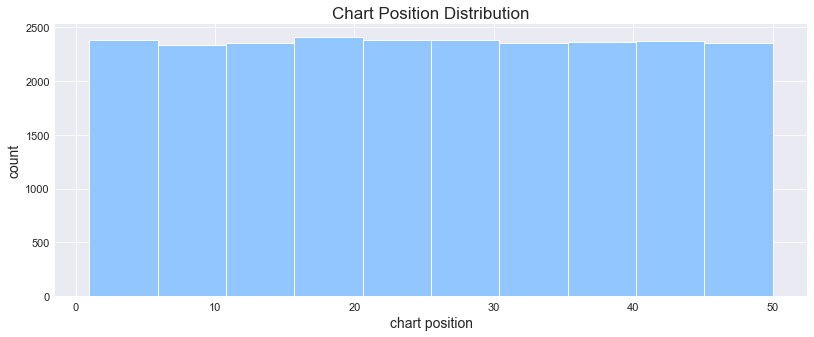

In [377]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-pastel')
from IPython.display import clear_output

plt.tight_layout()
all_data2['position'].hist(figsize=(12,5), ec='w', lw=1)
plt.title(s='Chart Position Distribution', size=17)
plt.xticks(size=11)
plt.yticks(size=11)
plt.xlabel(s='chart position', size=14)
plt.ylabel(s='count', size=14);

# Approach To Modeling
Chart positions tend to follow a predictable parabolic pattern. Roughly speaking, albums move up the charts for some time, stabilize, then reverse course until they leave the chart.

In [267]:
def chart_path(artist, cols, x, y):
    keys = ms[ms['artist']==artist]['key'].unique()
    plots = len(keys)
    rows = int(plots/cols) + (plots % cols)
    n = 1
    fig = plt.figure(figsize=(x,y))
    for k in keys:
        d = ms[ms['key'] == k]
        t = d['title'].values[0]
        yr = d['year'].values[0]
        plt.tight_layout(h_pad=4)
        plt.subplot(rows, cols, n)
        plt.plot('weeks_on_chart', 'position', data=d)
        plt.scatter('weeks_on_chart', 'position', data=d, alpha=1, color='orange', edgecolor='blue')
        plt.title(s=f'{t}, {yr}', size=x)
        plt.xlabel(s='Weeks On Chart', size=11)
        plt.ylabel(s='Chart Position', size=11)
        plt.xticks(size=9)
        plt.yticks(size=9)
        n += 1

The speed at which any of these steps happens is the variable: a highly anticipated album could hit \#1 from the jump and stay there for weeks, while a breakout album slowly gaining traction could take months before it reaches its peak.

As shown below, Chic's self-titled 1978 debut took 7 weeks to climb from \#45 its peak at \#12. Its took almost 3 more months before it was off the charts. Chic's sophomore album, "C'est Chic", debuted at \#3, hit \#1 the next week and stayed on top of the chart for another 3 months. But even though it was more successful, "C'est Chic" charted for 4 fewer weeks.

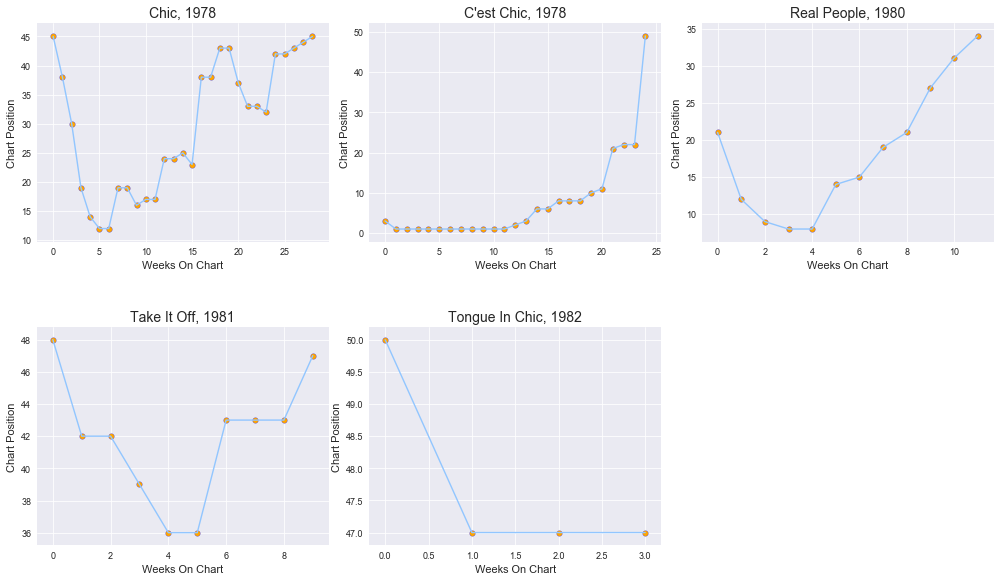

In [268]:
chart_path('Chic', 3, 14, 12)

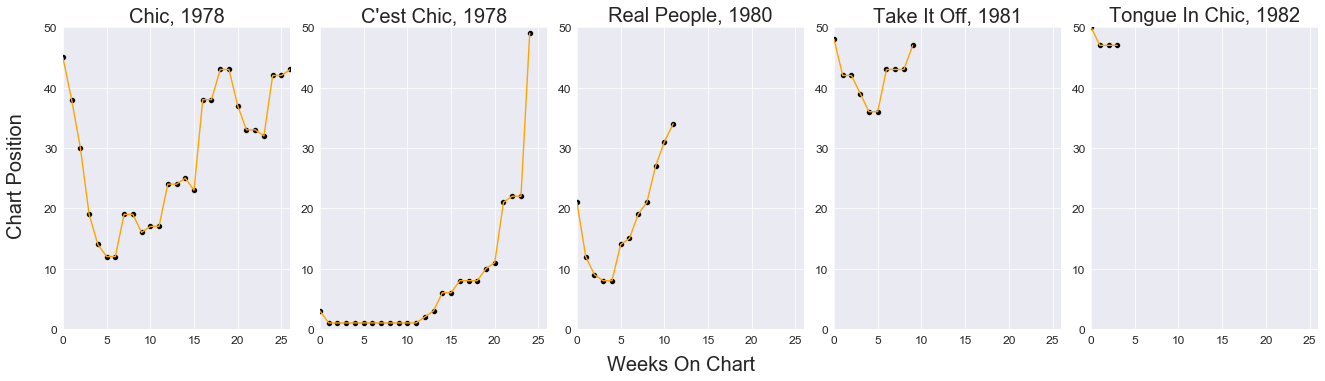

In [474]:
keys = ms[ms['artist']=='Chic']['key'].unique()
plots = len(keys)
cols = 5
rows = int(plots/cols) + (plots % cols)
n = 1
fig = plt.figure(figsize=(18,5))
fig.text(0.5, -0.04, 'Weeks On Chart', ha='center', size=20)
fig.text(-0.02, 0.5, 'Chart Position', va='center', rotation='vertical', size=20)
for k in keys:
    d = ms[ms['key'] == k]
    t = d['title'].values[0]
    yr = d['year'].values[0]
    plt.tight_layout(h_pad=4)
    plt.subplot(rows, cols, n)
    plt.plot('weeks_on_chart', 'position', color='orange', data=d)
    plt.scatter('weeks_on_chart', 'position', data=d, alpha=1, color='black', edgecolor='white')
    plt.title(s=f'{t}, {yr}', size=20)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.ylim((0, 50))
    plt.xlim((0,26))
    n += 1
    

Chart movement is generally slow, as illustrated by the distributions of the three features measuring week to week change

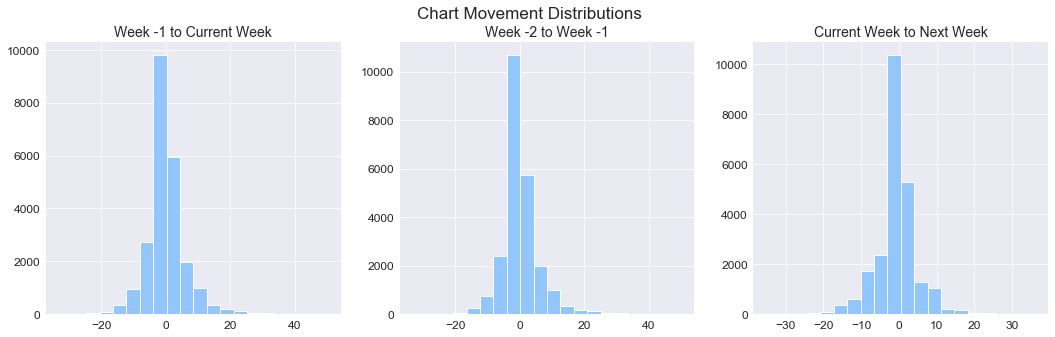

In [240]:
plt.figure(figsize=(16,5))
# plt.tight_layout(h_pad=2)
plt.suptitle(t='Chart Movement Distributions',size=17)

# plot 1 
plt.subplot(1,3,1)
all_data2['delta_1'].hist(ec='w', lw=1, bins=20)
plt.title(s='Week -1 to Current Week', size=14)
plt.xticks(size=12)
plt.yticks(size=12)


# plot 2
plt.subplot(1,3,2)
all_data2['delta_2'].hist(ec='w', lw=1, bins=20)
plt.title(s='Week -2 to Week -1', size=14)
plt.xticks(size=12)
plt.yticks(size=12)

# plot 3
plt.subplot(1,3,3)
all_data2['next_delta'].hist(ec='w', lw=1, bins=20)
plt.title(s='Current Week to Next Week', size=14)
plt.xticks(size=12)
plt.yticks(size=12);

Additionally an album moving in one direction tends to stay moving in that direction. As shown on the plots below, the size and direction of the movement in consecutive weeks are correlated.

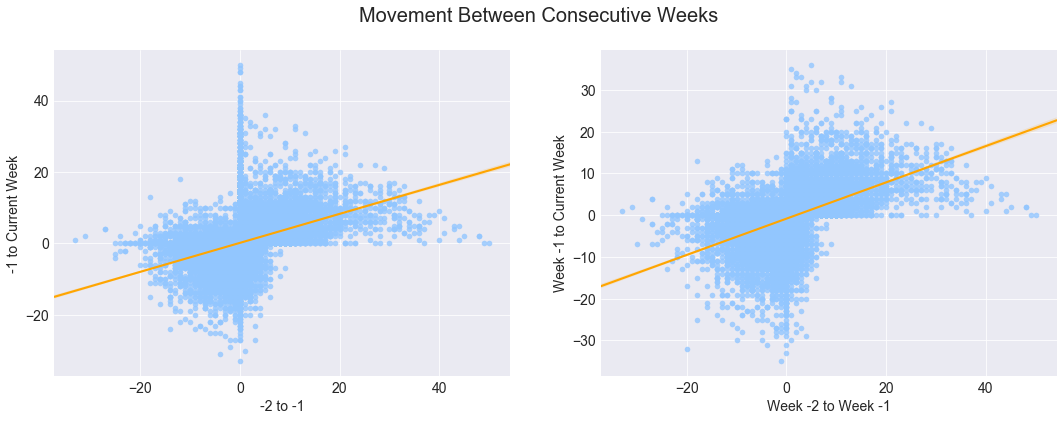

In [241]:
fig = plt.figure(figsize=(16,6))
plt.suptitle(t='Movement Between Consecutive Weeks', size=20)

# plot 1
plt.subplot(1,2,1)
sns.regplot(data=all_data2, x='delta_2', y='delta_1', fit_reg=False)
sns.regplot(data=all_data2, x='delta_2', y='delta_1', scatter=False, color='orange')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='-2 to -1', size=14)
plt.ylabel(s='-1 to Current Week', size=14)

# plot 2
plt.subplot(1,2,2)
sns.regplot(data=all_data2, x='delta_1', y='next_delta', fit_reg=False)
sns.regplot(data=all_data2, x='delta_1', y='next_delta', scatter=False, color='orange')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Week -2 to Week -1', size=14)
plt.ylabel(s='Week -1 to Current Week', size=14);

In [140]:
import matplotlib
matplotlib.get_configdir()

'/Users/af412 1/.matplotlib'

So, an album's momentum (so to speak) is a fairly good predictor of where it will go next ... but not perfect. As shown below, previous movement only predicts next movement about half the time.

In [242]:
move_1 = all_data2['delta_1'].map(lambda x: 'up' if x > 0 else ('stay' if x == 0 else 'down'))
move_0 = all_data2['delta_2'].map(lambda x: 'up' if x > 0 else ('stay' if x == 0 else 'down'))
L = len(all_data)

print('% Identical Motion from Week -2 to Week -1 and Week -1 to Current Week:')
print((move_0 == move_1).sum()/L)
print('')

print('% Identical Motion from Week -1 to Current Week and Current Week to Next Week:')
print((move_1 == all_data2['move_2']).sum()/L)

% Identical Motion from Week -2 to Week -1 and Week -1 to Current Week:
0.496264719537

% Identical Motion from Week -1 to Current Week and Current Week to Next Week:
0.536571983286


The new features added to the model are intended to better contextualize the album's chart performance, thus aiding it in predicting whether it will move and in which direction.

For example, as an album stays on the charts, it becomes less likely to move, and much more likely to move downward if it does move.

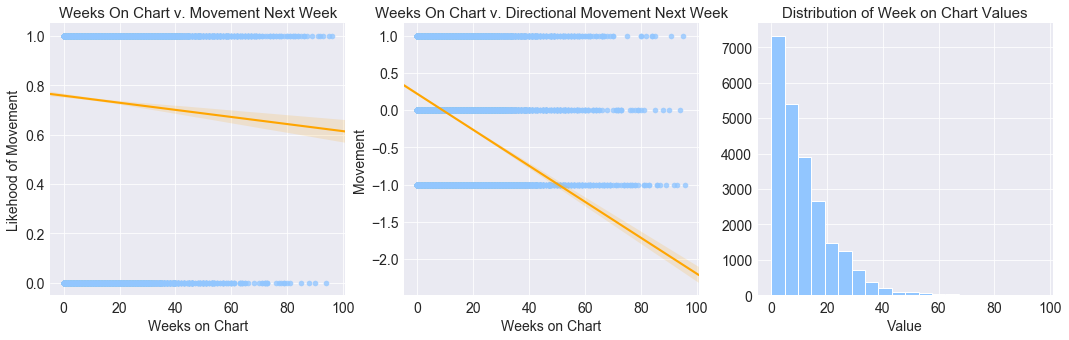

In [273]:
all_data['move_2n'] = all_data['move_2'].map(lambda x: 0 if x == 'stay' else (1 if x == 'up' else -1))
plt.figure(figsize=(16,5))
plt.tight_layout()

# weeks on chart v. movement (binary)
plt.subplot(1,3,1)
sns.regplot(data=all_data2, x='weeks_on_chart', y='move', fit_reg=False)
sns.regplot(data=all_data2, x='weeks_on_chart', y='move', scatter=False, color='orange')
plt.title(s='Weeks On Chart v. Movement Next Week', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Weeks on Chart', size=14)
plt.ylabel(s='Likehood of Movement', size=14)

# weeks on chart v. directional movement
plt.subplot(1,3,2)
sns.regplot(data=all_data2, x='weeks_on_chart', y='move_2n', fit_reg=False)
sns.regplot(data=all_data2, x='weeks_on_chart', y='move_2n', scatter=False, color='orange')
plt.title(s='Weeks On Chart v. Directional Movement Next Week', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Weeks on Chart', size=14)
plt.ylabel(s='Movement', size=14)

# distribution of weeks on chart
plt.subplot(1,3,3)
all_data2['weeks_on_chart'].hist(ec='w', lw=1, bins=20)
plt.title(s='Distribution of Week on Chart Values', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Value', size=14);

And while lower-charting albums are more likely to move, it's tough to say which direction they will go.

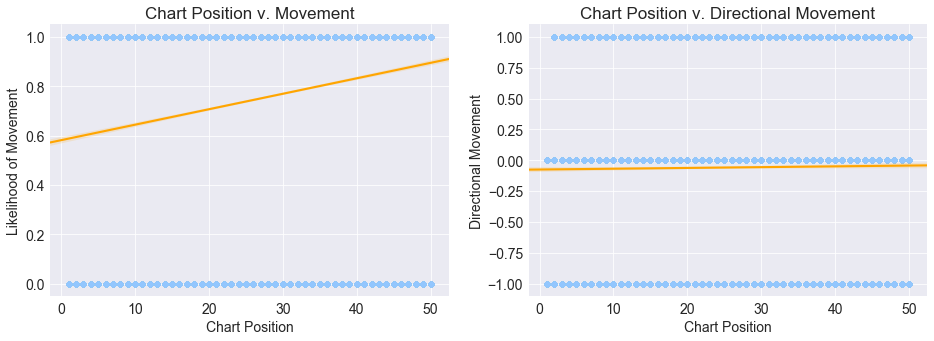

In [244]:
plt.figure(figsize=(14,5))
plt.tight_layout()

# chart position v. movement
plt.subplot(1,2,1)
sns.regplot(data=all_data2, x='position', y='move', fit_reg=False)
sns.regplot(data=all_data2, x='position', y='move', scatter=False, color='orange')
plt.title(s='Chart Position v. Movement', size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Chart Position', size=14)
plt.ylabel(s='Likelihood of Movement', size=14)

# chart position v. directional movement
plt.subplot(1,2,2)
sns.regplot(data=all_data2, x='position', y='move_2n', fit_reg=False)
sns.regplot(data=all_data2, x='position', y='move_2n', scatter=False, color='orange')
plt.title(s='Chart Position v. Directional Movement', size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Chart Position', size=14)
plt.ylabel(s='Directional Movement', size=14);

In [230]:
all_data2['pos_diff'] = all_data2['position'] - all_data2['avg_position']

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [250]:
corr_cols = [
    'position', 'next_delta','delta_1','delta_2','weeks_on_chart','avg_weeks_on_chart',
    'total_albums', 'total_credits', 'unique_credits', 'peak', 'total_weeks', 'move',
    'move_2n', 'pos_diff']

corr = all_data2[corr_cols].corr()

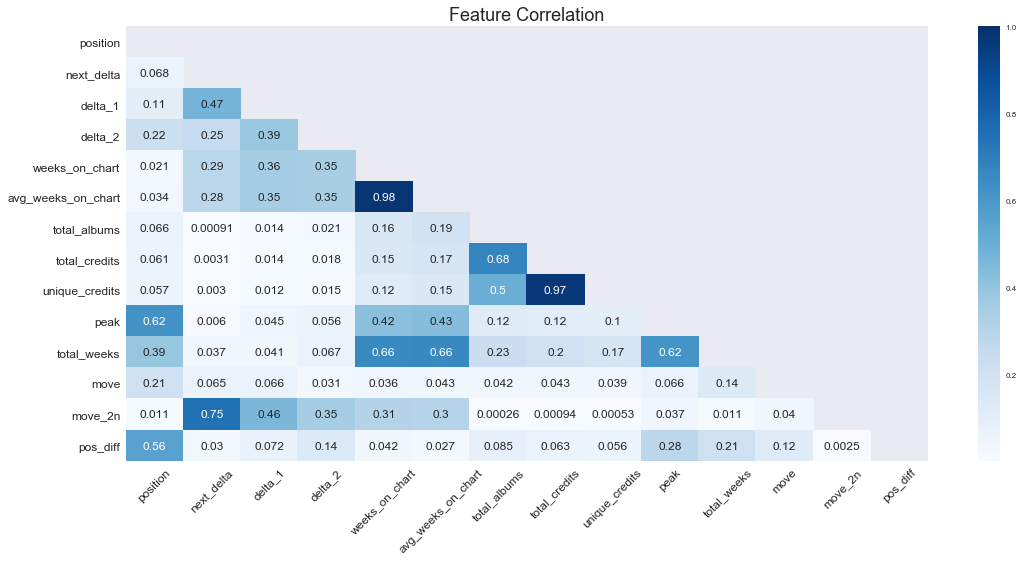

In [272]:
fig = plt.figure(figsize=(16,8))
plt.title(s='Feature Correlation', size=18)

# define mask
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# make heatmap
sns.heatmap(abs(corr), annot=True, annot_kws={'size':12}, cmap='Blues', mask=mask)
plt.xticks(size=12, rotation=45)
plt.yticks(size=12);

TALK ABOUT DROPPING REDUNDANT FEATURES HERE

# Modeling

To minimize redundancies, models used the following features:

name | data
:---|:---
 **position**| chart position on that date
 **delta_1**| movement between last chart and this chart
 **delta_2**| movement between two charts ago and last chart
 **weeks_on_chart**| how many consecutive weeks the album has charted
 **total_albums**| avg of total charting albums for each person on album
 **total_credits**| avg of total credits on charting albums for each person on album
 **peak**| peak chart position of artist's previous album
 **total_weeks**| how many consecutive weeks the artist's previous album charter
 **pos_diff**| difference between chart position and avg personnel chart position

To start, I modeled the data with a variety of classification algorithms, predicting 'move_2' ('up', 'down' or 'stay'). 

Accuracy scores were fairly comparable across models, with an accuracy of between 0.63 and 0.68.

In [440]:
scores = pd.read_csv('data_safe/reg_scores.csv')
scores[scores['target']=='both'][['model','train','test']]

,model,train,test
0,Random Forest,0.984,0.646
1,Random Forest + Grid Search,0.702,0.663
2,SVC,0.924,0.633
3,Linear SVC,0.618,0.631
4,AdaBoost,0.653,0.658
5,Logistric Regression,0.643,0.643
6,XGBoost,0.674,0.680


(The baseline for accuracy is the frequency of the most frequent class, so in this case our baseline is 0.39.)

In [390]:
all_data2['move_2'].value_counts(normalize=True)

down    0.399890
up      0.341586
stay    0.258524
Name: move_2, dtype: float64

Visually, it's easy to see how SVC and Random Forest overfit (and how grid searching to improve parameters reduced overfitting in Random Forest).

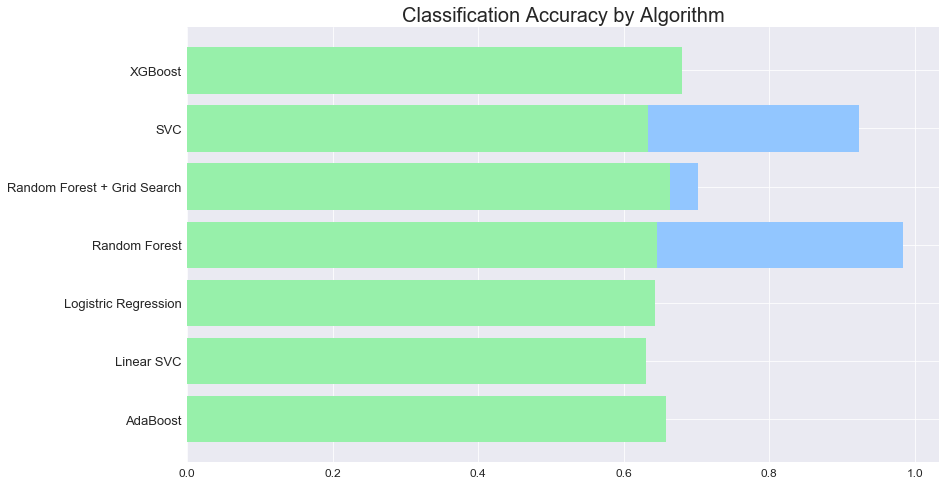

In [484]:
fig = plt.figure(figsize=(12,8))

plt.title('Classification Accuracy by Algorithm', size=20)
plt.barh(data=scores[scores['target']=='both'], y='model', width='train')
plt.barh(data=scores[scores['target']=='both'], y='model', width='test')
plt.yticks(size=13)
plt.xticks(size=12);

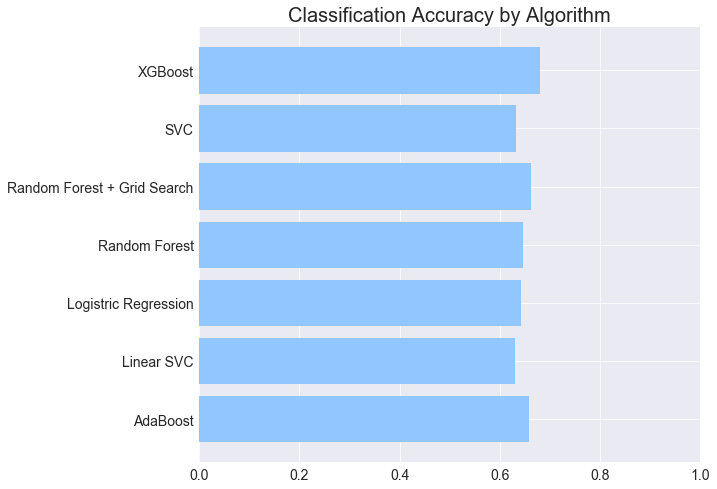

In [488]:
fig = plt.figure(figsize=(8,8))

plt.title('Classification Accuracy by Algorithm', size=20)
plt.barh(data=scores[scores['target']=='both'], y='model', width='test')
plt.yticks(size=14)
plt.xticks(size=14)
plt.xlim(0,1);

But a closer look at the scores by the three classification categories undercuts the effectiveness of the model.

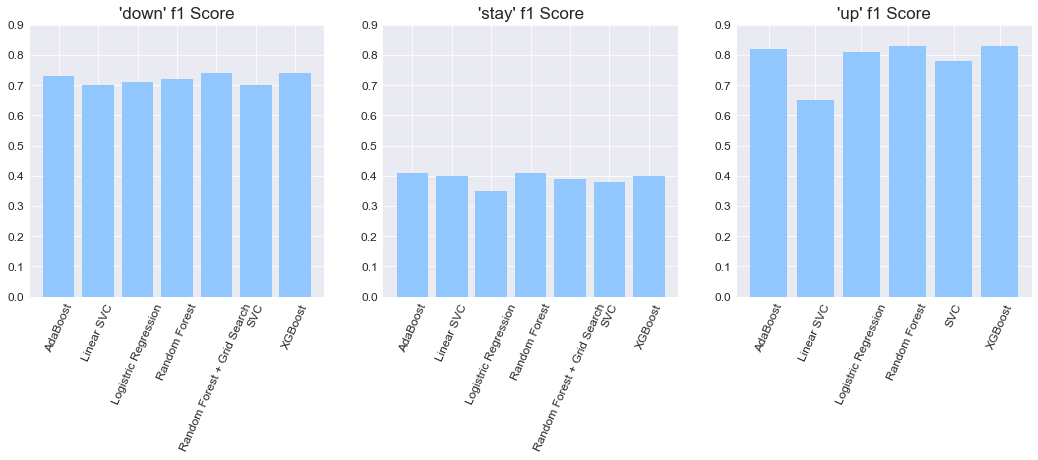

In [439]:
# f1 score by class
fig = plt.figure(figsize=(16,5))
plt.tight_layout()

# both
plt.subplot(1,3,1)
plt.title(s='\'down\' f1 Score', size=17)
plt.bar(data=scores[scores['target']=='both'], x='model', height='down f1')
plt.xticks(rotation=66, size=12)
plt.yticks(size=12)
plt.ylim((0, 0.9))

# movement
plt.subplot(1,3,2)
plt.title(s='\'stay\' f1 Score', size=17)
plt.bar(data=scores[scores['target']=='both'], x='model', height='stay f1')
plt.xticks(rotation=66, size=12)
plt.yticks(size=12)
plt.ylim((0, 0.9))

# dir
plt.subplot(1,3,3)
plt.title(s='\'up\' f1 Score', size=17)
plt.bar(data=scores[scores['target']=='dir'], x='model', height='up f1')
plt.xticks(rotation=66, size=12)
plt.yticks(size=12)
plt.ylim((0, 0.9));

All of the algorithms can predict downward movement pretty well and upward movement even better, but are much worse at deciding whether or not an album will move in the first place.

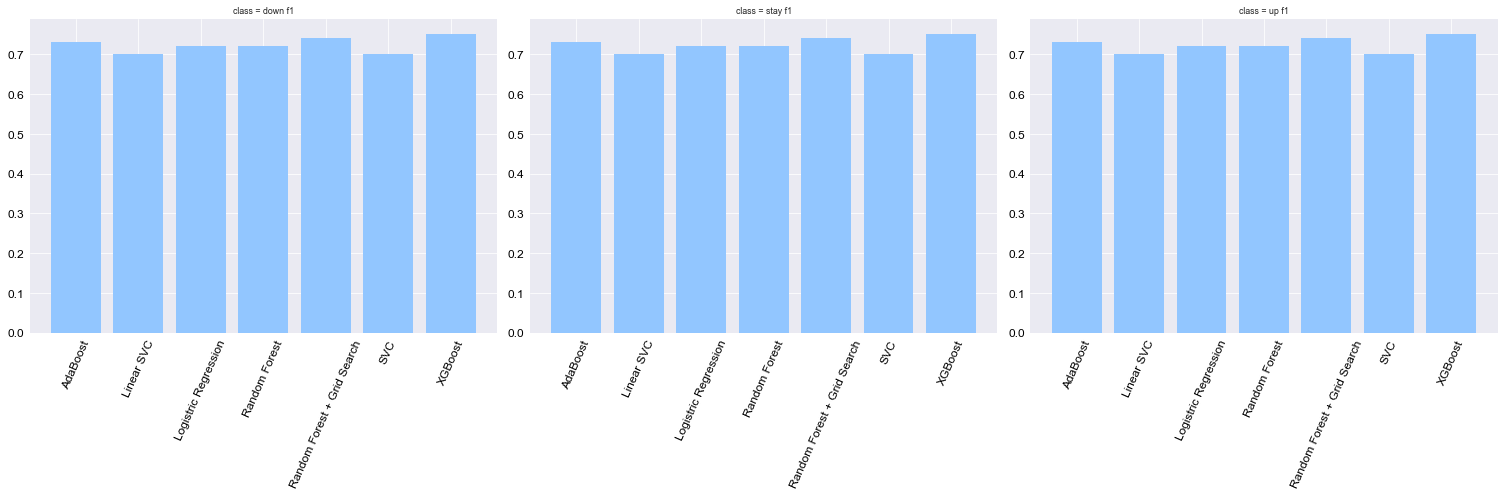

In [431]:
d = scores[scores['target'] == 'both'].melt(id_vars=['model'], value_vars=['down f1', 'stay f1', 'up f1'], value_name='f1 score', var_name='class')
g = sns.FacetGrid(d, col='class', size=7, aspect=1)
plt.tight_layout(h_pad=5)
g.map(plt.bar, x=d['model'], height=d['f1 score'])
g.map(plt.xticks, rotation=66, color='black', size=12)
g.map(plt.yticks, color='black', size=12);

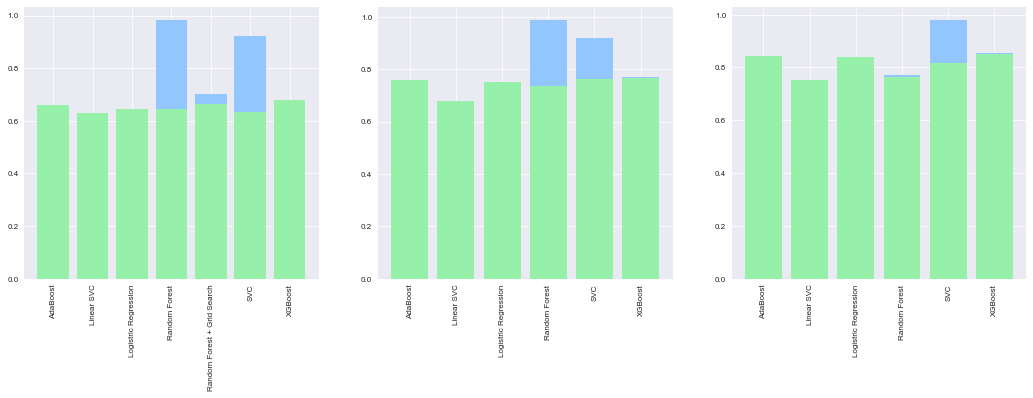

In [392]:
# accuracy by target
fig = plt.figure(figsize=(16,5))
plt.tight_layout()

# both
plt.subplot(1,3,1)
plt.bar(data=scores[scores['target']=='both'], x='model', height='train')
plt.bar(data=scores[scores['target']=='both'], x='model', height='test')
plt.xticks(rotation=90)

# movement
plt.subplot(1,3,2)
plt.bar(data=scores[scores['target']=='move'], x='model', height='train')
plt.bar(data=scores[scores['target']=='move'], x='model', height='test')
plt.xticks(rotation=90)

# dir
plt.subplot(1,3,3)
plt.bar(data=scores[scores['target']=='dir'], x='model', height='train')
plt.bar(data=scores[scores['target']=='dir'], x='model', height='test')
plt.xticks(rotation=90);

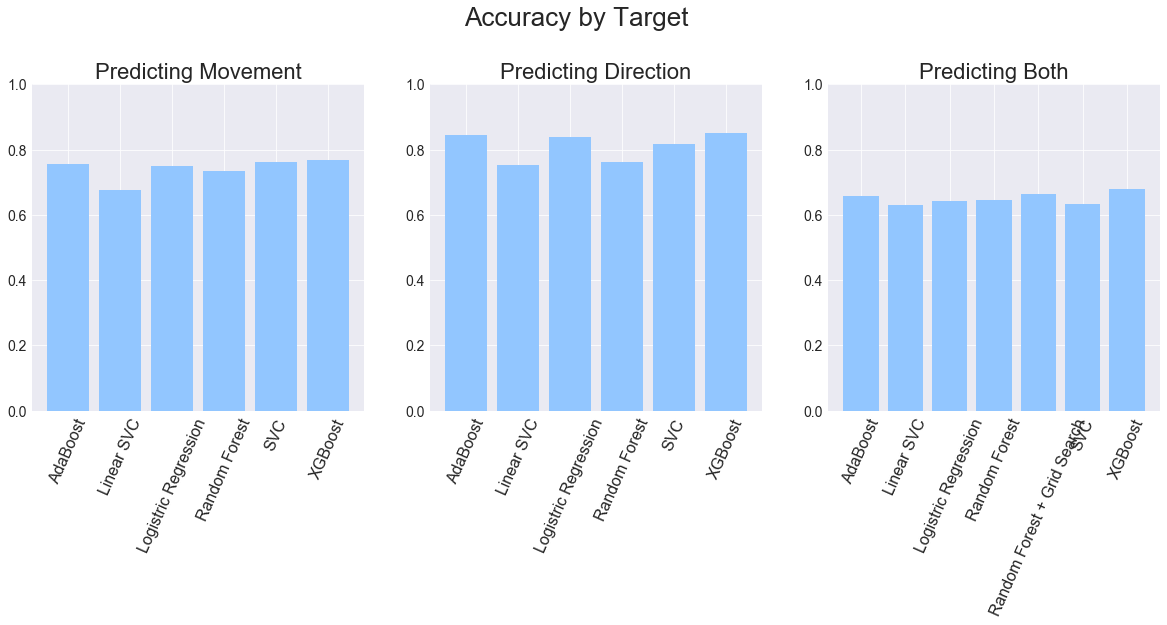

In [513]:
# accuracy by target
fig = plt.figure(figsize=(18,6))
plt.suptitle(t='Accuracy by Target', size=26, y=1.06)

# movement
plt.subplot(1,3,1)
plt.title(s='Predicting Movement', size=22)
plt.bar(data=scores[scores['target']=='move'], x='model', height='test')
plt.xticks(rotation=66, size=16)
plt.yticks(size=14)
plt.ylim((0, 1))

# dir
plt.subplot(1,3,2)
plt.title(s='Predicting Direction', size=22)
plt.bar(data=scores[scores['target']=='dir'], x='model', height='test')
plt.xticks(rotation=66, size=16)
plt.yticks(size=14)
plt.ylim((0, 1))

# both
plt.subplot(1,3,3)
plt.title(s='Predicting Both', size=22)
plt.bar(data=scores[scores['target']=='both'], x='model', height='test')
plt.xticks(rotation=66, size=16)
plt.yticks(size=14)
plt.ylim((0, 1));

In [345]:
scores2 = scores.melt(id_vars=['model','target'], value_vars=['train', 'test'], var_name='data', value_name='score')

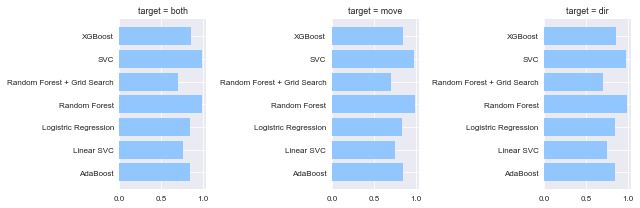

In [355]:
d = scores
g = sns.FacetGrid(d, col='target')
g.map(plt.barh, y=d['model'], width=d['train'])
g.map(plt.barh, y=d['model'], width=d['test'])